In [17]:
import torch 
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

## TO DOs
* ~~import CelebA .csv~~
* ~~compute percentage of men and women for any other categories~~
    * ~~visualisation~~
* print the top 36 images
* import features space after TSNE
    * print such a space with points colored with a heatmap according with the ranking score
* ~~compute distribution of our ranking score for every category~~
    * ~~visualisation~~
* import the result of partial clustering 
    * print the centroid for every cluster

In [35]:
# paths 
celebA_csv = "../data/celeba/list_attr_celeba.csv"
results = "../results"

In [7]:
# import celebA data
df = pd.read_csv(celebA_csv)

df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [14]:
# for every attribute, compute the percentage of men and women with that attribute
n_male = len(df[df["Male"] == 1])
n_female = len(df[df["Male"] == -1])

bias = dict()

for col in df.columns:
    n_male_col = len(df[(df["Male"] == 1) & (df[col] == 1)])
    n_female_col = len(df[(df["Male"] == -1) & (df[col] == 1)])
    
    bias[col] = {"Male" : n_male_col/n_male,
                 "Female" : n_female_col/n_female}

bias.pop("image_id")
bias.pop("Male")

{'Male': 1.0, 'Female': 0.0}

In [32]:
# function that saves barplots
def make_barplot(path, column, values):
    plt.bar(["Male", "Female"], [val for key, val in values.items()], color = ["mediumseagreen", "mediumpurple"])
    plt.title(column)
    plt.savefig(path + "/{}.jpeg".format(column))

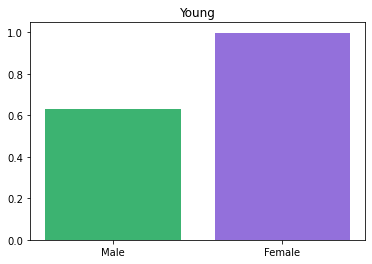

In [37]:
# save the barplots
for col, values in bias.items():
    make_barplots(results + "/barplots_celeba", col, values)

In [38]:
# foo colums, to be replaced with the actual ranking score 
df["foo"] = np.random.normal(size=len(df))

In [51]:
def make_histograms(path, df, col, score, gender = "Male"):
    plt.hist(df[df[col] == 1][score])
    plt.title(gender + " " + col)
    #plt.savefig(path + "/{}.jpeg".format(col))
    plt.show()

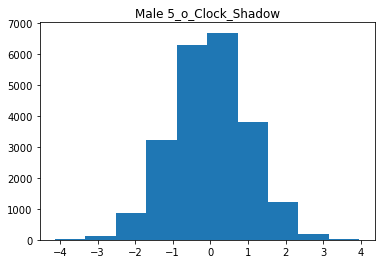

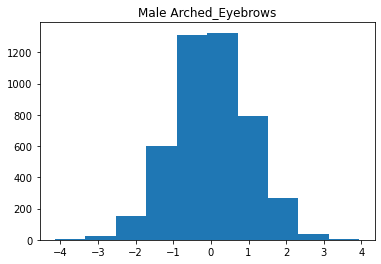

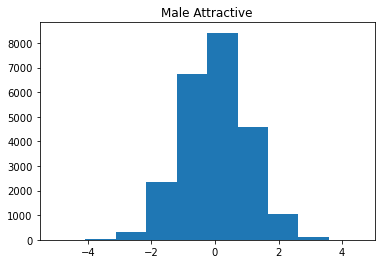

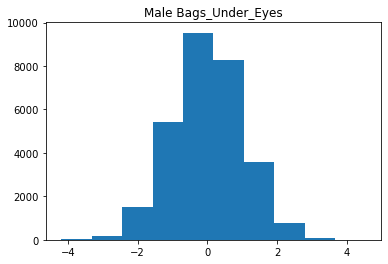

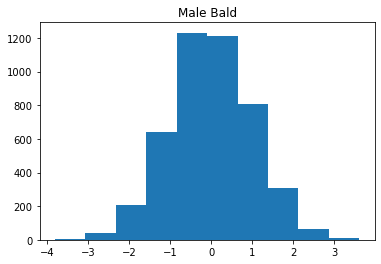

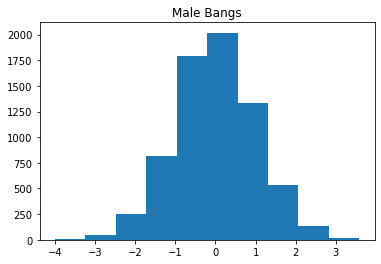

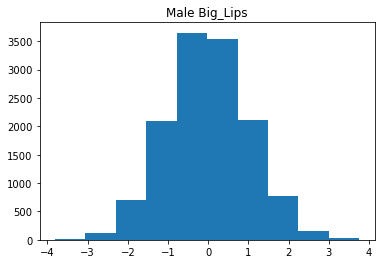

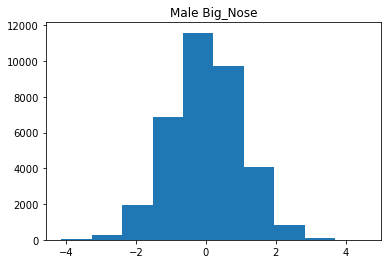

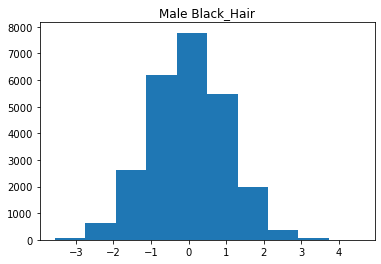

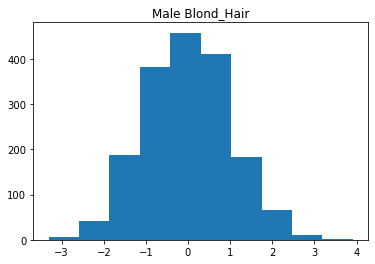

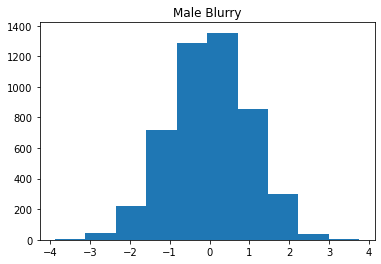

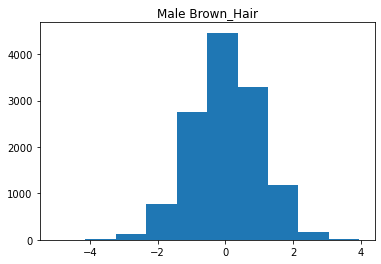

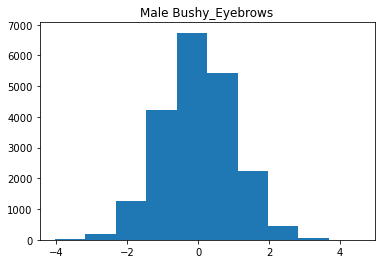

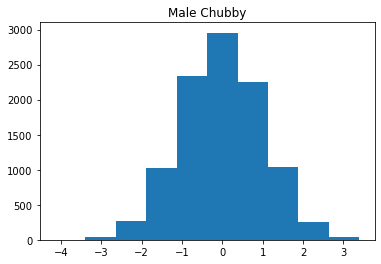

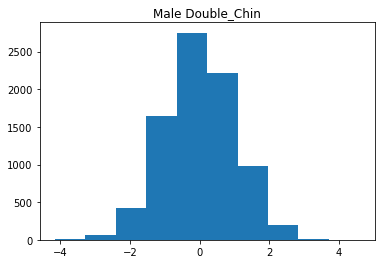

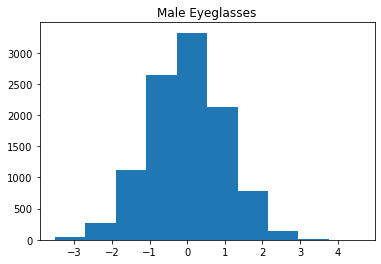

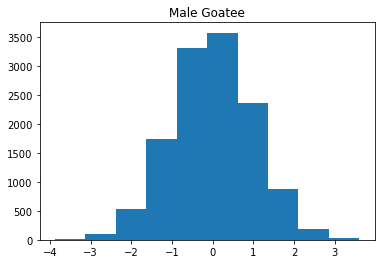

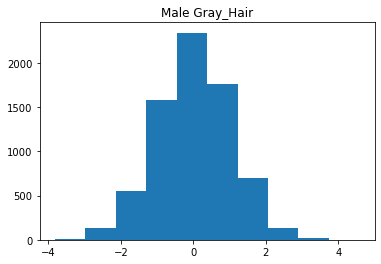

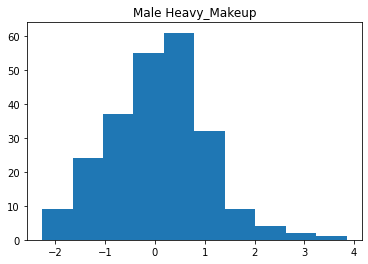

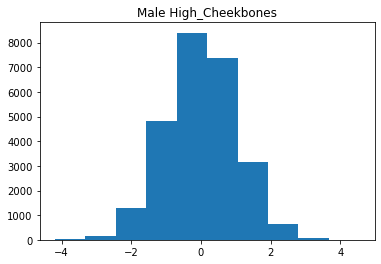

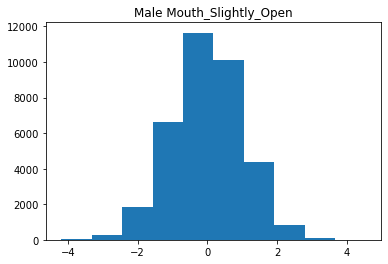

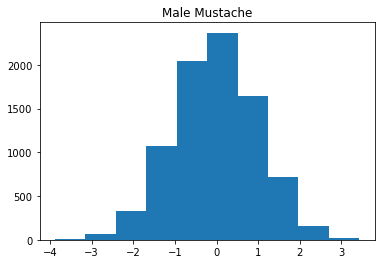

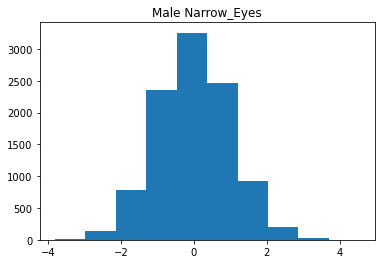

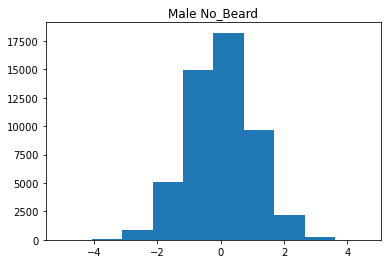

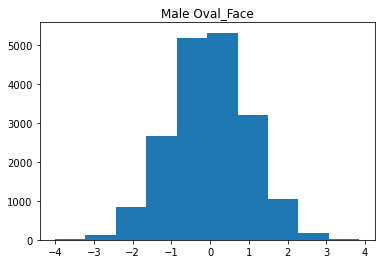

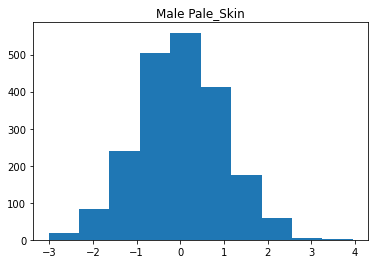

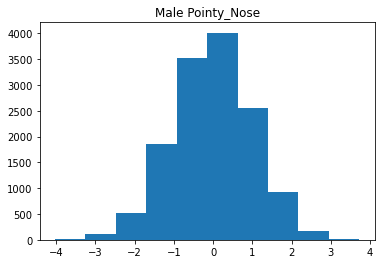

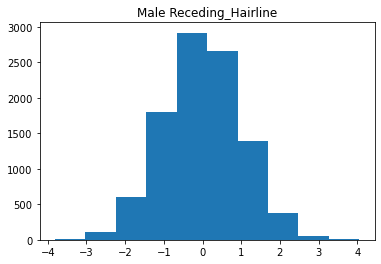

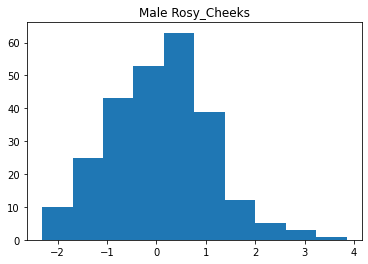

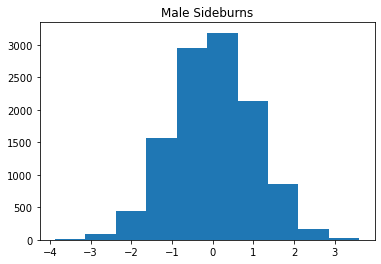

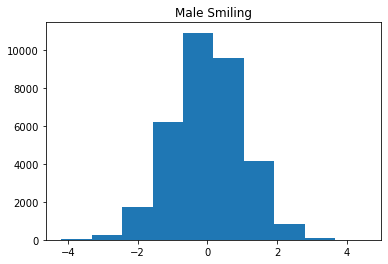

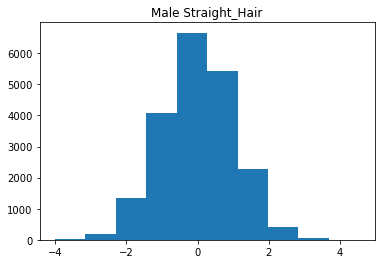

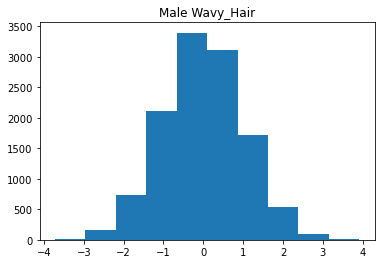

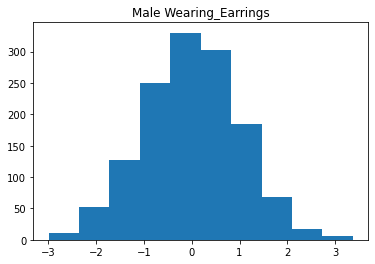

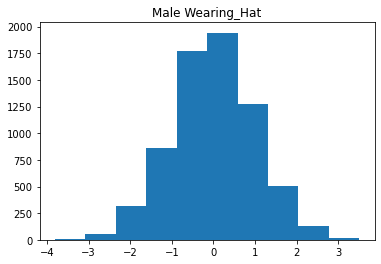

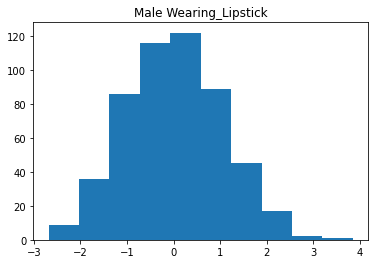

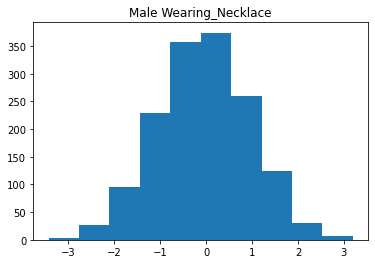

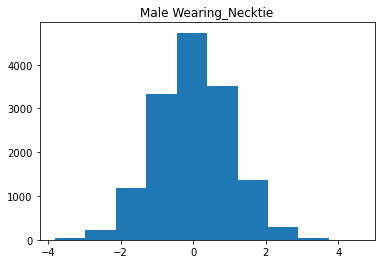

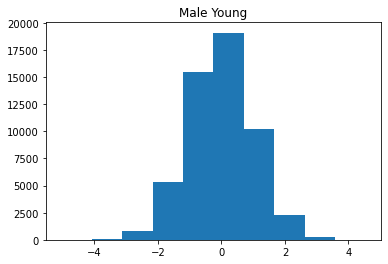

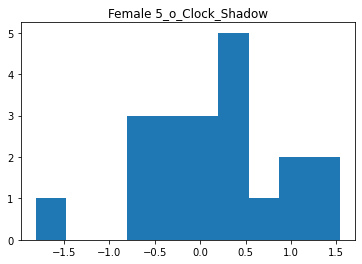

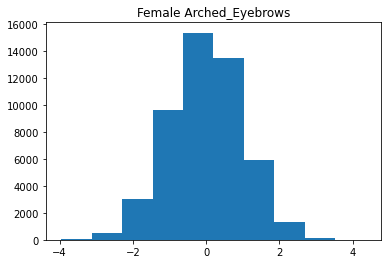

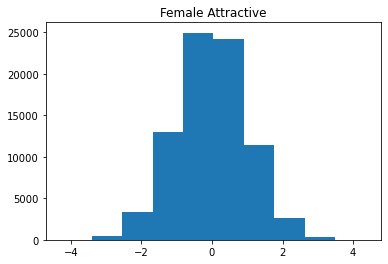

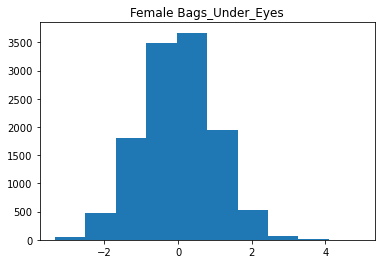

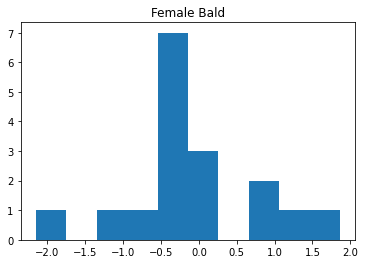

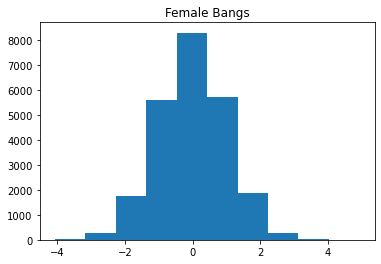

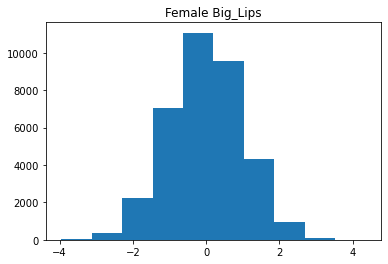

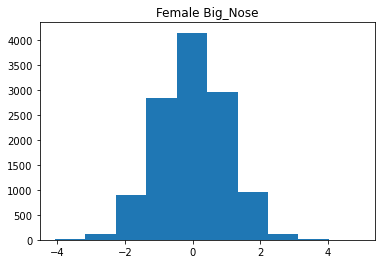

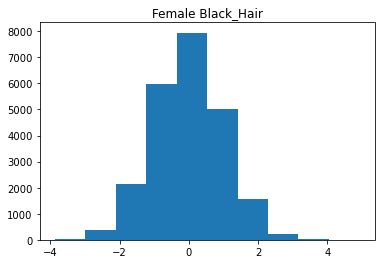

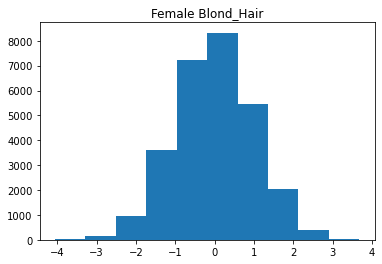

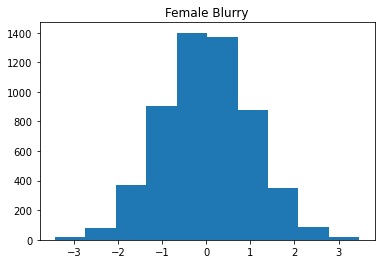

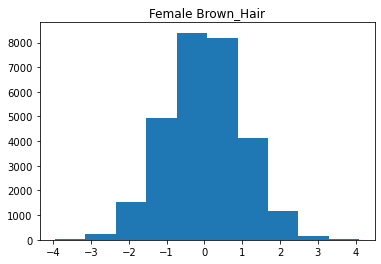

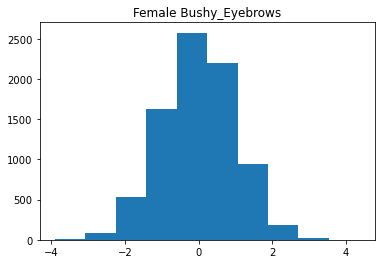

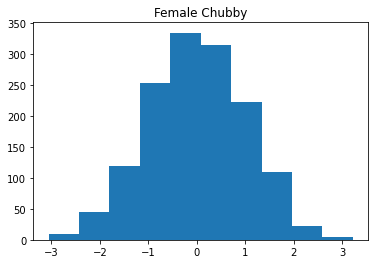

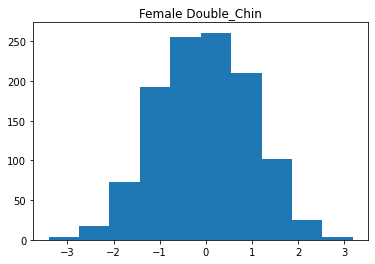

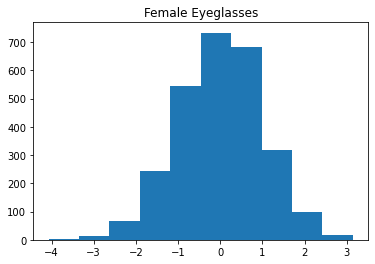

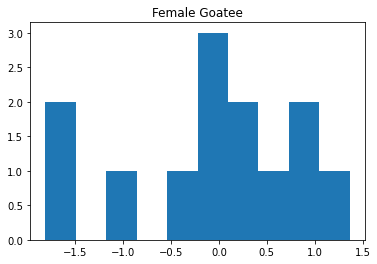

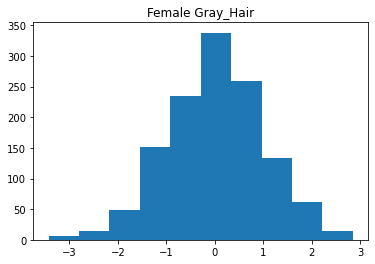

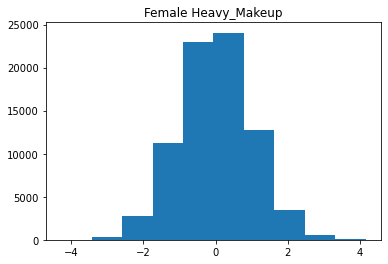

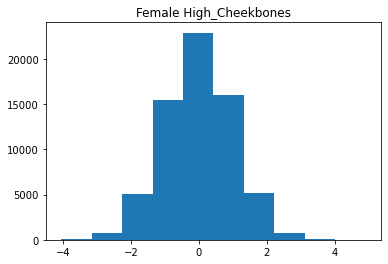

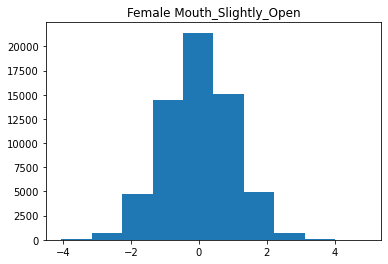

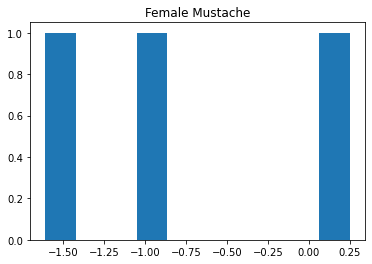

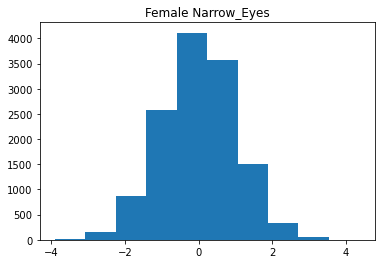

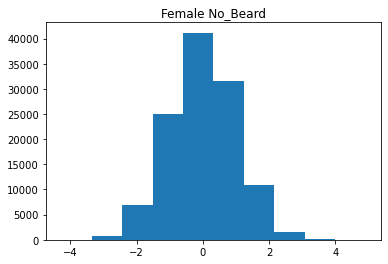

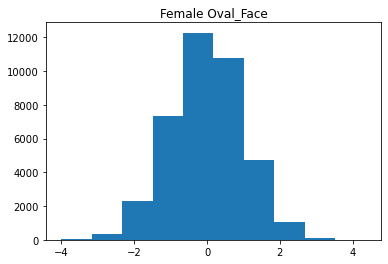

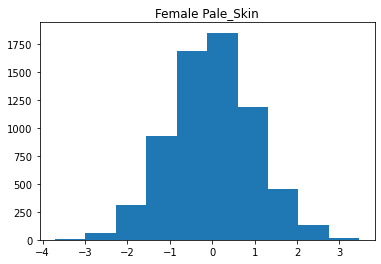

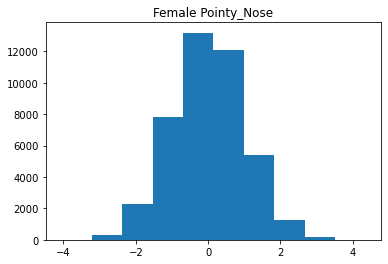

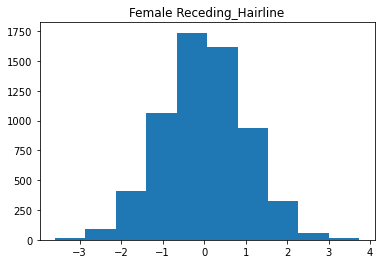

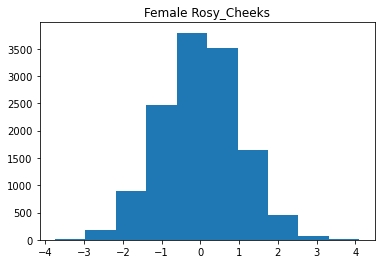

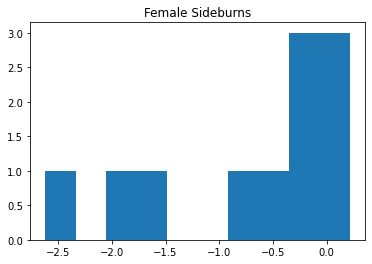

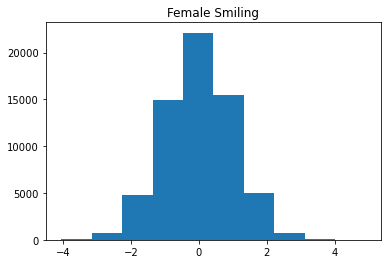

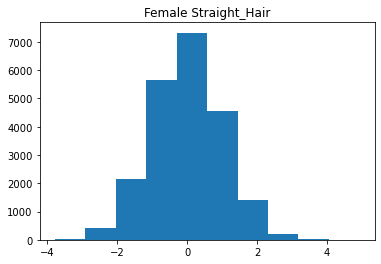

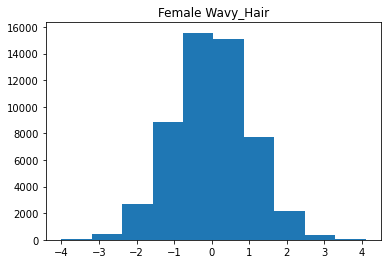

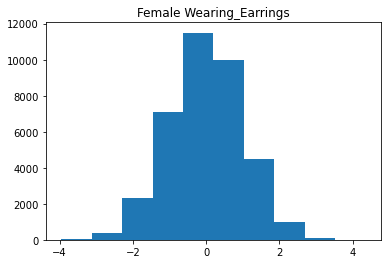

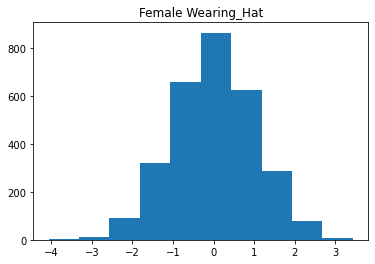

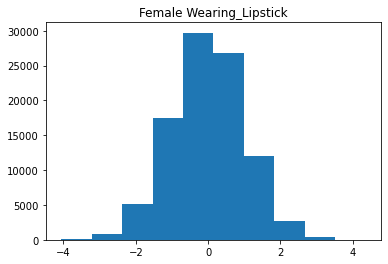

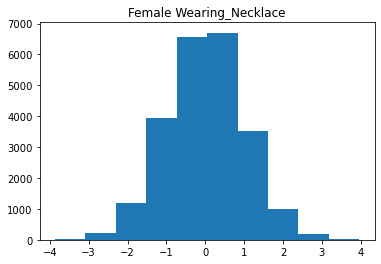

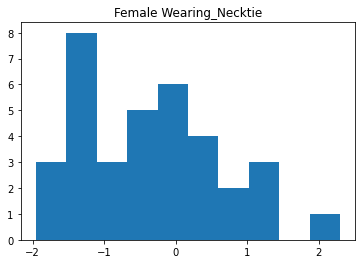

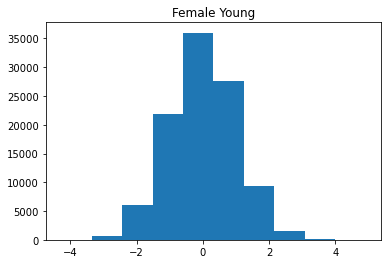

In [52]:
for male in [1,-1]:
    df_gender = df[df["Male"] == male]
    if male == 1:
        gender = "Male"
    else:
        gender = "Female"
    for col in bias.keys():
        make_histograms(results + "/histograms_celeba", df_gender, col, "foo", gender)